In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Bernoulli
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

CUDA

In [2]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

Environment

In [3]:
from multiprocessing_env import SubprocVecEnv

num_envs = 20
env_name = "CartPole-v1"

def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env
    return _thunk
envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)
env = gym.make(env_name)
actsize=env.action_space.n
obssize=env.observation_space.shape[0]

Network

In [4]:
class ActorCritic(nn.Module):
    def __init__(self, obssize,actsize, hidden_size=24):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(obssize, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(obssize, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, actsize),
            nn.Softmax()
        )
        self.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        prob    = self.actor(x)[:,1]
        dist  = Bernoulli(prob)        
        return dist, value

Util

In [5]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.1)
def plot(x, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('ite %d reward: %s' % (x, rewards[-1]))
    plt.plot(rewards)
    plt.show()   
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        action = dist.sample()
        next_state, reward, done, _ = env.step(int(action.cpu().numpy()[0]))
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

delta(t)=reward(t)+ gamma * V(t+1) -V(t),
Ahat(t)=delta(t)+gamma * Ahat(t-1),
Q(t)=return(t)=Ahat(t)+V(t)

PPO

In [6]:
def ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantage):
    batch_size = len(states)
    for _ in range(batch_size // mini_batch_size):
        rand_ids = np.random.randint(0, batch_size, mini_batch_size)
        yield states[rand_ids, :], actions[rand_ids], log_probs[rand_ids], returns[rand_ids], advantage[rand_ids]
        
        

def ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantages, clip_param=0.3):
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, return_, advantage in ppo_iter(mini_batch_size, states, actions, log_probs, returns, advantages):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)

            ratio = (new_log_probs - old_log_probs).exp()
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantage

            actor_loss  = - torch.min(surr1, surr2).mean()
            critic_loss = (return_ - value).pow(2).mean()
            
            loss =  critic_loss + actor_loss - 0.01 * entropy

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

hyperparameters

In [7]:
hidden_size      = 24
lr               = 1e-4
num_sample       = 8
mini_batch_size  = 8
ppo_epochs       = 8
episodes = 100
len_sample = 500

In [8]:
model = ActorCritic(obssize, actsize, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

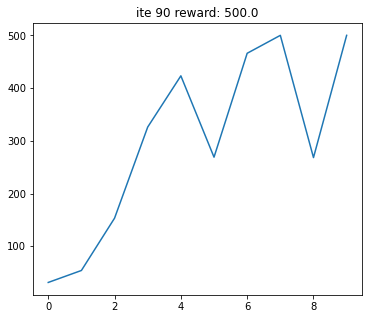

In [9]:
state = env.reset()
test_rewards = []
counter = 0
counts = []
for i in range(episodes):
    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    entropy = 0
    for _ in range(num_sample):
        for _ in range(len_sample): 
            counter += 1
            state = torch.FloatTensor(state).to(device)
            dist, value = model(state.unsqueeze(0))

            action = dist.sample()
            next_state, reward, done, _ = env.step(int(action.cpu().numpy()[0]))
            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()
        
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)
            masks.append(1 - done)
            states.append(state)
            actions.append(action) 
            state = next_state
            if done:
                state = env.reset()
    if i%10 == 0:
        test_reward = np.mean([test_env() for _ in range(10)])
        test_rewards.append(test_reward)
        plot(i, test_rewards)       
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state.unsqueeze(0))
    returns = compute_gae(next_value, rewards, masks, values)

    returns   = torch.cat(returns).detach()
    log_probs = torch.cat(log_probs).detach()
    values    = torch.cat(values).detach()
    states    = torch.stack(states)
    actions   = torch.cat(actions)
    advantage = returns - values
    
    ppo_update(ppo_epochs, mini_batch_size, states, actions, log_probs, returns, advantage)